# Benchmark recombination and mutation rates estimation error and computation time

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
import recombulatorx
import recombulatorx.testing

In [2]:
n_cores = 10

In [3]:
try:
    from tqdm import tqdm
except ModuleNotFoundError:
    tqdm = lambda x: x
    print('tqdm module not found, no progress bars!')

In [4]:
from time import time

def random_estimation_test(n_markers, n_fam_I, n_fam_II, seed=None, **kwargs):
    if seed is not None:
        numpy.random.seed(seed)
    simulated_rates = recombulatorx.testing.generate_random_rates(n_markers)
    fams = [recombulatorx.testing.generate_processed_family(f'FAM_I_{i}', 2, True, *simulated_rates) for i in range(n_fam_I)]
    fams += [recombulatorx.testing.generate_processed_family(f'FAM_II_{i}', 2, False, *simulated_rates) for i in range(n_fam_II)]
    t1 = time()
    estimated_rates = recombulatorx.estimate_rates(fams, 0.1, 0.1, **kwargs)
    elapsed_time = time() - t1
    return simulated_rates, estimated_rates, elapsed_time

In [5]:
try:
    import joblib
    mem = joblib.Memory('estimation_testing_cache', verbose=0)
    random_estimation_test = mem.cache(random_estimation_test)
except ModuleNotFoundError:
    print('joblib module not found, cannot cache results')

In [6]:
from multiprocessing import Pool
def random_estimation_test_p(args):
    return random_estimation_test(*args[:-1], estimate_mutation_rates='all', **args[-1])
    
def random_estimation_tests(n_markers, n_fam_I, n_fam_II, n_tests, **kwargs):
    args_list = [(n_markers, n_fam_I, n_fam_II, seed, kwargs) for seed in range(n_tests)]
    with Pool(n_cores) as p:
        data = list(p.imap(random_estimation_test_p, args_list))
    
    # put results in a pandas DataFrame
    recomb_cols = [('RECOMBINATION', f'M{i}-{i+1}') for i in range(1, n_markers)]
    mut_cols = [('MUTATION', f'M{i}') for i in range(1, n_markers + 1)]
    all_cols = [(l1, *l2) for l1 in ['SIMULATED', 'ESTIMATED'] for l2_cols in [recomb_cols, mut_cols] for l2 in l2_cols] + [('ELAPSED TIME', None, None)]

    df = pandas.DataFrame(
        [
            numpy.concatenate([*simulated_rates, *estimated_rates, [elapsed_time]])
            for simulated_rates, estimated_rates, elapsed_time in data
        ], 
        columns=pandas.MultiIndex.from_tuples(all_cols, names=['SOURCE', 'RATE', 'MARKER']))
    df.index.name = 'TEST'
    return df

In [7]:
#random_estimation_test(200, 1000, 0, 0, optimization_method='Nelder-Mead', maxiter=10000)

In [8]:
#random_estimation_test(200, 1000, 0, 0, optimization_method='L-BFGS-B', maxiter=10000)

In [9]:
#random_estimation_test(200, 1000, 0, 0, optimization_method='Powell', maxiter=10000)

In [10]:
#random_estimation_test(200, 1000, 0, 0, optimization_method='TNC', maxiter=10000)

In [11]:
#random_estimation_tests(n_markers=12, n_fam_I=100, n_fam_II=0, n_tests=1)

## Tests comparing to literature

Nothnagel and colleagues analyzed 216 type I and 185 type II families genotyped with a panel of 12 markers \cite{Nothnagel_2012}

In [12]:
lit1 = random_estimation_tests(n_markers=12, n_fam_I=216, n_fam_II=185, n_tests=10)

In [13]:
lit1_minutes = lit1.loc[:, ('ELAPSED TIME', None, None)]/60
print(f'average time (minutes): {lit1_minutes.mean()}, std: {lit1_minutes.std()}')

average time (minutes): 2.3819389990965525, std: 0.4429687566369809


In [14]:
lit2 = random_estimation_tests(n_markers=15, n_fam_I=54, n_fam_II=104, n_tests=10)

In [15]:
lit2_minutes = lit2.loc[:, ('ELAPSED TIME', None, None)]/60
print(f'average time (minutes): {lit2_minutes.mean()}, std: {lit2_minutes.std()}')

average time (minutes): 14.296912101109822, std: 2.012808439566107


# Tests varying the number of markers

In [16]:
n_fam_I = 100
n_fam_II = 0
marker_tests = {}
for n_markers in range(10, 130, 10):
    print(f'{n_markers=}')
    marker_tests[n_markers] = random_estimation_tests(n_markers, n_fam_I, n_fam_II, 10)

n_markers=10
n_markers=20
n_markers=30
n_markers=40
n_markers=50
n_markers=60
n_markers=70
n_markers=80
n_markers=90
n_markers=100
n_markers=110
n_markers=120


<AxesSubplot: xlabel='MARKERS', ylabel='ELAPSED TIME'>

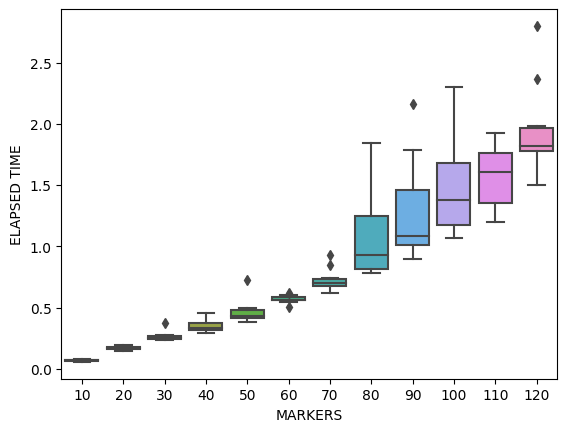

In [17]:
plot_data = pandas.concat({k: df[('ELAPSED TIME', None, None)] for k, df in marker_tests.items()}, names=['MARKERS']).reset_index()
plot_data.columns = plot_data.columns.get_level_values(0)
seaborn.boxplot(plot_data, x='MARKERS', y='ELAPSED TIME');

In [19]:
n_fam_I = 100
n_fam_II = 100
marker_tests_II = {}
for n_markers in range(6, 18, 2):
    print(f'{n_markers=}')
    marker_tests_II[n_markers] = random_estimation_tests(n_markers, n_fam_I, n_fam_II, 10)

n_markers=6
n_markers=8
n_markers=10
n_markers=12
n_markers=14
n_markers=16


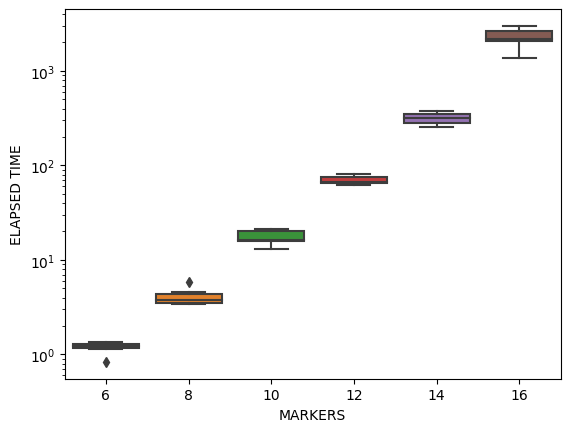

In [20]:
plot_data = pandas.concat({k: df[('ELAPSED TIME', None, None)] for k, df in marker_tests_II.items()}, names=['MARKERS']).reset_index()
plot_data.columns = plot_data.columns.get_level_values(0)
seaborn.boxplot(plot_data, x='MARKERS', y='ELAPSED TIME')
plt.yscale('log')

# Prove, mettere da qualche altra parte

In [ ]:
acc = {}
mae_acc = {}
for n_markers, df in marker_tests.items():
    delta = df['ESTIMATED'] - df['SIMULATED']
    mae_acc[n_markers] = delta.abs().mean()
    stats = delta.stack().apply(['mean', 'std'])
    stats['TIME'] = df[('ELAPSED TIME', None, None)].apply(['mean', 'std'])
    #stats = stats.unstack(level=0)
    #stats['MAE'] = delta.abs().mean()
    acc[n_markers] = stats
    #delta.apply(['mean', 'std'])
df = pandas.concat(acc, names=['n_markers'])
df

In [ ]:
pandas.concat(mae_acc, names=['n_markers']).reset_index().groupby(['n_markers', 'RATE']).mean()

In [ ]:
df.loc[(slice(None), slice('mean')), :]

In [ ]:
if False:
    n_markers = 12
    delta = marker_tests[n_markers]['ESTIMATED'] - marker_tests[n_markers]['SIMULATED']
    delta.to_csv('delta12.csv')
    delta.columns = delta.columns.get_level_values('MARKER')
    delta.boxplot(figsize=(8, 4))
    import matplotlib.pyplot as plt
    plt.xticks(rotation=90);
    plt.savefig('deltas12.pdf')

In [ ]:
print(pandas.concat(acc, names=['n_markers']).to_latex())

# Tests varying the number of families

In [ ]:
n_markers = 15
n_fam_II = 0
n_tests = 100
fam_I_acc = {}
for n_fam_I_log2 in range(1, 11):
    n_fam_I = 2**n_fam_I_log2
    fam_I_acc[n_fam_I] = random_estimation_tests(n_markers, n_fam_I, n_fam_II, n_tests)

In [ ]:
assert False

In [ ]:
delta = df['ESTIMATED'] - df['SIMULATED']
delta.head()

In [ ]:
delta.apply(['mean', 'std'])

In [ ]:
delta.plot.box()

In [ ]:
ratio = numpy.log2(df['ESTIMATED']/df['SIMULATED'])
ratio.head()

In [ ]:
r = ratio.stack(['RATE', 'MARKER'])
s = df.loc[:, 'SIMULATED'].stack(['RATE', 'MARKER'])
r.loc[s >= 1e-3].unstack(['RATE', 'MARKER']).plot.box()

In [ ]:
r.loc[s >= 1e-3].std()

In [ ]:
r.loc[s >= 1e-2].unstack(['RATE', 'MARKER']).quantile([0.025, 0.5, 0.975])

In [ ]:
seaborn.displot(r.loc[s >= 1e-2])

In [ ]:
pandas.concat([
    df.drop('ELAPSED TIME', axis=1).stack(['RATE', 'MARKER']), 
    pandas.DataFrame({'r': r, 's': s})
], axis=1).sort_values('r')

In [ ]:
s >= 1e04

In [ ]:
delta.loc[sorted(delta.abs().idxmax())]

In [ ]:
df.loc[sorted(delta.abs().idxmax()), (['SIMULATED', 'ESTIMATED'], 'RECOMBINATION', )]

In [ ]:
df.loc[sorted(delta.abs().idxmax()), [('SIMULATED', 'RECOMBINATION')]]

In [ ]:
seaborn.boxplot(data=delta)

In [ ]:
seaborn.displot(df[('ELAPSED TIME', None, None)])